# Final Project Data Science: Study Case dari Credit Card Churn

- Nama: Irfan Wahyu Ramadhani
- Email: iramadhani679@gmail.com

# 1. Persiapan

## 1.1 Mempersiapkan Library

In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

## 1.2 Mempersiapkan Data

In [343]:
df = pd.read_csv('Credit Card Churn - Dataset.csv')
df.head()

,client_id,label,usia,gender,jumlah_tanggungan,pendidikan,status_nikah,penghasilan_tahunan,tipe_kartu_kredit,lama_nasabah,...,bulan_nonactive,jumlah_kontak,total_limit_kredit,total_limit_kredit_dipakai,sisa_limit_kredit,rasio_transaksi_Q4_Q1,total_transaksi,jumlah_transaksi,rasio_jumlah_transaksi_Q4_Q1,rasio_pemakaian
0,719455083,0,48,F,3,Uneducated,Single,Less than $40K,Blue,39,...,3,4,2991.0,1508,1483.0,0.703,3734,64,0.882,0.504
1,773503308,0,59,M,1,Uneducated,Single,Less than $40K,Blue,53,...,5,4,2192.0,1569,623.0,0.706,4010,79,0.717,0.716
2,715452408,0,37,F,2,Graduate,Divorced,Less than $40K,Blue,36,...,3,3,1734.0,987,747.0,0.879,4727,67,0.914,0.569
3,711264033,0,47,M,3,Doctorate,Divorced,$40K - $60K,Blue,36,...,2,3,4786.0,1516,3270.0,0.940,4973,74,0.850,0.317
4,718943508,0,42,M,3,Unknown,Single,$80K - $120K,Blue,33,...,3,2,3714.0,2170,1544.0,0.524,1454,35,0.522,0.584


# 2. Data Understanding

Tim bisnis di sebuah bank semakin resah dengan semakin banyaknya nasabah yang menutup layanan kartu kreditnya. Untuk mencegah hal ini terjadi, tim berencana untuk memberikan treatment/layanan yang khusus kepada customers yang berencana akan churn (menutup layanan kartu kreditnya), sehingga customers tersebut berubah pikiran dan mengurungkan niat untuk churn.
Agar rencana treatment yang dilakukan tepat sasaran, tim harus membuat sebuah predictive model untuk memprediksi siapa saja customers yang akan churn

### Berikut adalah keterangan dari data yang akan digunakan

- client_id : ID dari masing-masing customer
- label : status churn dari customer (1 : churn ; 0 : no churn)
- usia : usia dari customer (tahun)
- gender : jenis kelamin (M = Male, F = Female)
- jumlah_tanggungan : jumlah tanggungan customer
- pendidikan : tingkat pendidikan customer (high school, college graduate, etc.)
- status_nikah : status nikah (married, single, divorced, unknown)
- penghasilan_tahunan : kategori penghasilan tahunan customer (dalam $)
- tipe_kartu_kredit : tipe kartu kredit yang dipegang customer (Blue, Silver, Gold, Platinum)
- lama_nasabah : lama customer sudah menjadi nasabah (bulan)
- jumlah_produk : jumlah produk yang dimiliki customer
- bulan_nonactive : lama customers tidak aktif dalam 12 bulan terakhir (dalam bulan)
- jumlah_kontak : jumlah kontak dalam 12 bulan terakhir
- total_limit_kredit : total limit kredit yang diperoleh oleh customer
- total_limit_kredit_dipakai : total limit kredit yang sudah dipakai oleh customer
- sisa_limit_kredit : sisa limit kredit yang dimiliki customer
- rasio_transaksi_Q4_Q1 : rasio total nominal transaksi di Q4 terhadap Q1
- total_transaksi : total nominal transaksi dalam 12 bulan terakhir
- jumlah_transaksi : jumlah transaksi dalam 12 bulan terakhir
- rasio_jumlah_transaksi_Q4_Q1 : rasio jumlah transaksi di Q4 terhadap Q1
- rasio_pemakaian : rasio pemakaian limit kredit


dari analisis penjelasan data yang digunakan, analisis terhadap aktivitas transaksi nasabah dalam menggunakan kartu kredit akan dilakukan. analisis ini dimaksudkan apakah aktivitas transaksi nasabah selama satuan waktu tertentu menggunakan kartu kredit akan mempengaruhi nasabah menutup kartu kredit atau tidak.


### Analisis Masalah
* faktor yang mempengaruhi tingginya nasabah menutup layanan kartu kredit (Churn)
### Fokus yang dianalisis
* Label
* tipe_kartu_kredit
* rasio_transaksi_Q4_Q1
* total_transaksi
* jumlah_transaksi
* rasio_jumlah_transaksi_Q4_Q1

## 2.1 Exploratory Data Analysis

### 2.1.1 Analsisi Jumlah Churn

<Axes: xlabel='label'>

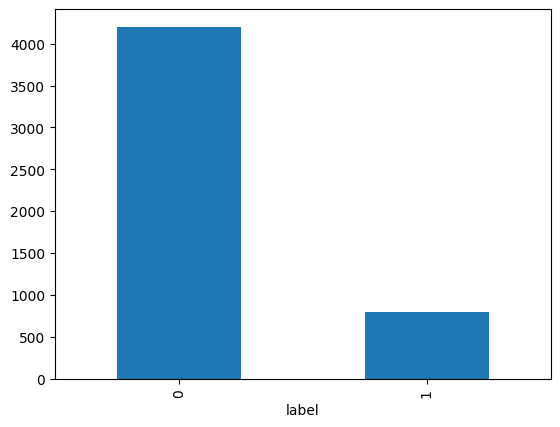

In [344]:
df['label'].value_counts().plot(kind='bar')

jumlah nasabah yang melakukan Churn ternyata tidak samapai setengah dari nasabah yang tidak Churn.
jumlah ini tentu tidak seimbang jika digunakan untuk pembuatan model. maka mungkin akan dilakukan sampling.

### 2.1.2 Analsis tipe kartu kredit

<Axes: xlabel='tipe_kartu_kredit'>

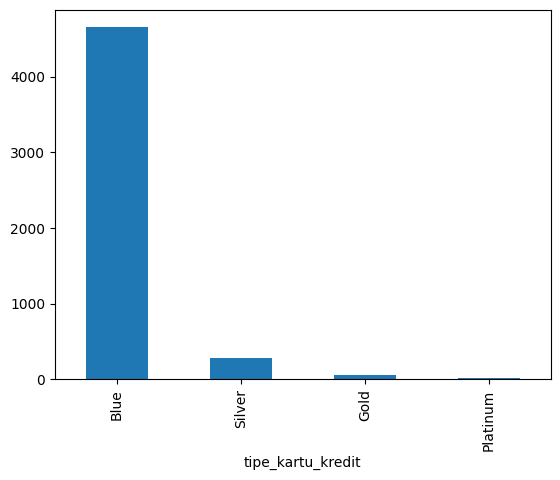

In [345]:
df['tipe_kartu_kredit'].value_counts().plot(kind='bar')

banyak nasabah yang menggunakan tipe kartu kredit blue

#### hubungan tipe kartu kredit dan status nasabah

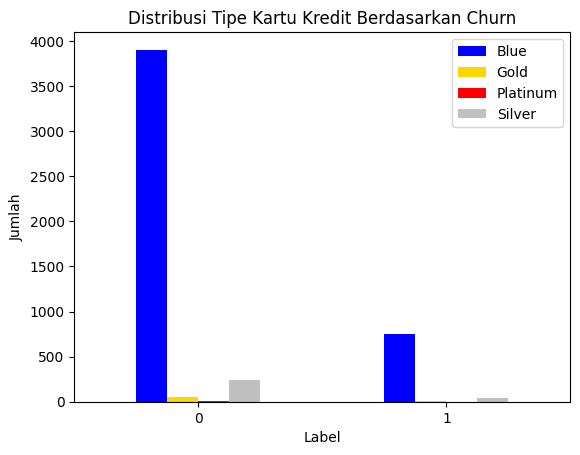

In [346]:
group = df.groupby(['label', 'tipe_kartu_kredit']).size().unstack()

group.plot(kind='bar', color=['blue', 'gold', 'red', 'silver'])
plt.title('Distribusi Tipe Kartu Kredit Berdasarkan Churn')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.legend()
plt.show()

pada nasabah Churn, ternyata banyak juga dengan tipe kartu kredit blue, disusul silver, dan seterusnya

### 2.1.3 Analisis Transaksi

#### 2.1.3.1 Rasio Q4 terhadap Q1

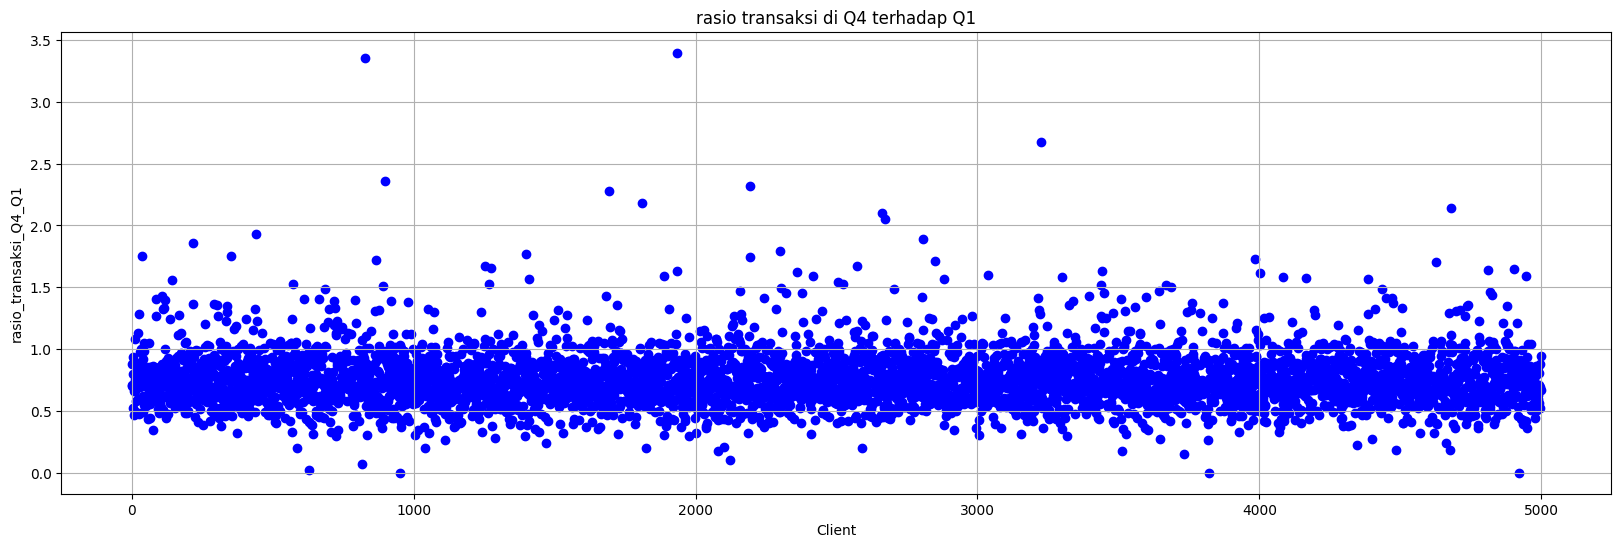

In [347]:
plt.figure(figsize=(20, 6))
plt.scatter(df.index, df['rasio_transaksi_Q4_Q1 '], color='b')
plt.title('rasio transaksi di Q4 terhadap Q1')
plt.xlabel('Client')
plt.ylabel('rasio_transaksi_Q4_Q1')
plt.grid(True)
plt.show()

#### 2.1.3.2 total transaksi

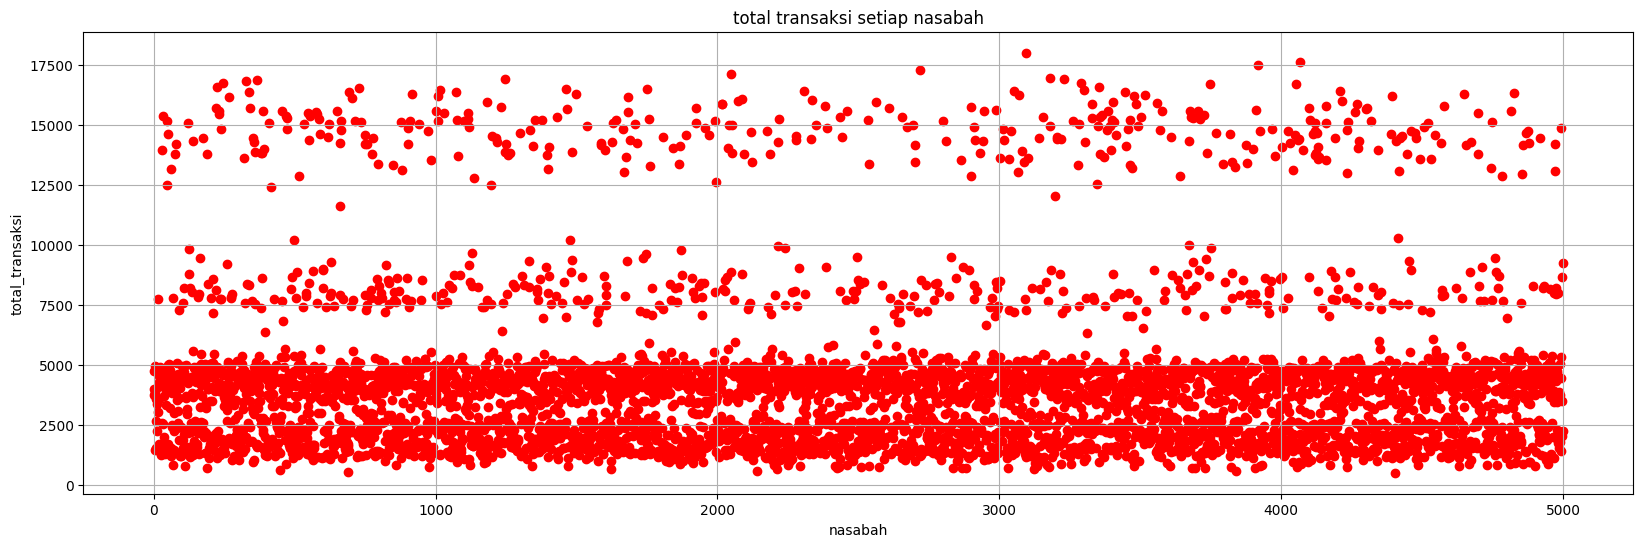

In [348]:
plt.figure(figsize=(20, 6))
plt.scatter(df.index, df['total_transaksi'], color='r')
plt.title('total transaksi setiap nasabah')
plt.xlabel('nasabah')
plt.ylabel('total_transaksi')
plt.grid(True)
plt.show()

secara kasat mata, terlihat seperti ada 3 kelompok nasabah yang bersasarkan total transaksi

#### 2.1.3.3 Jumlah Transaksi

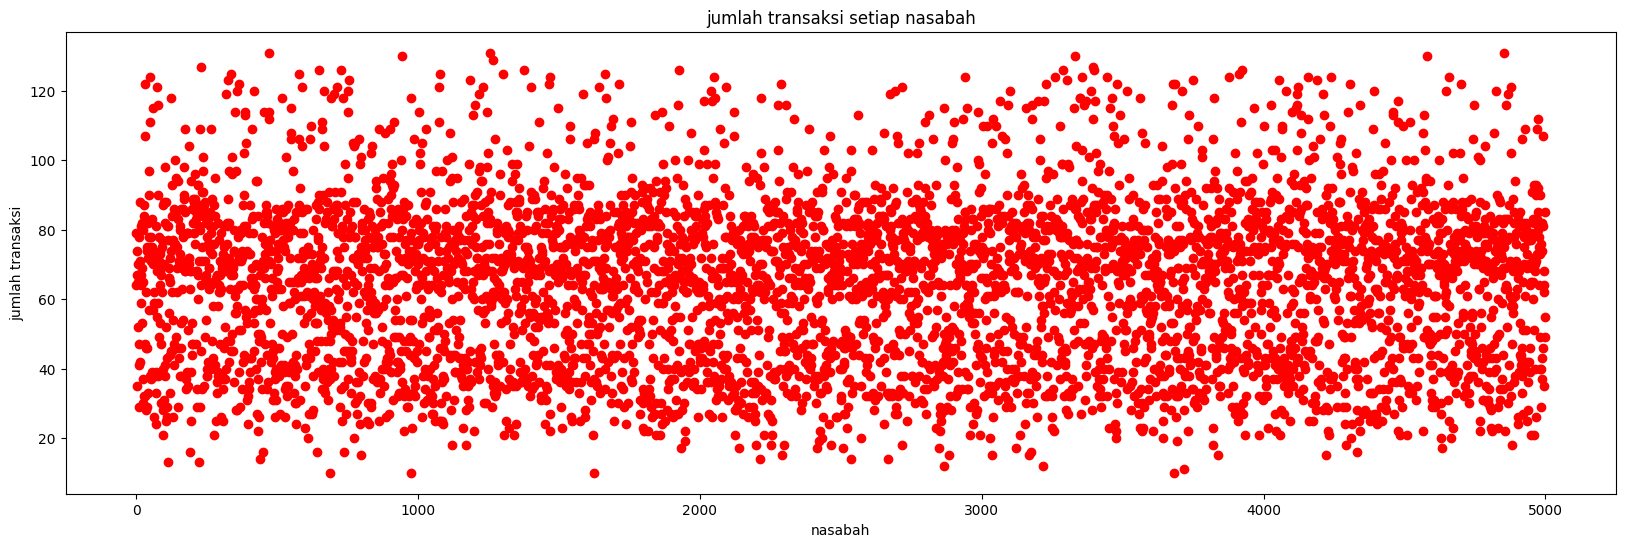

In [349]:
plt.figure(figsize=(20, 6))
plt.scatter(df.index, df['jumlah_transaksi'], color='r')
plt.title('jumlah transaksi setiap nasabah')
plt.xlabel('nasabah')
plt.ylabel('jumlah transaksi')
plt.show()

jumlah transaksi tiap nasabah sangat bervariasi

#### 2.1.3.4 Rasio Jumlah Transaksi Q4 terhadap Q1

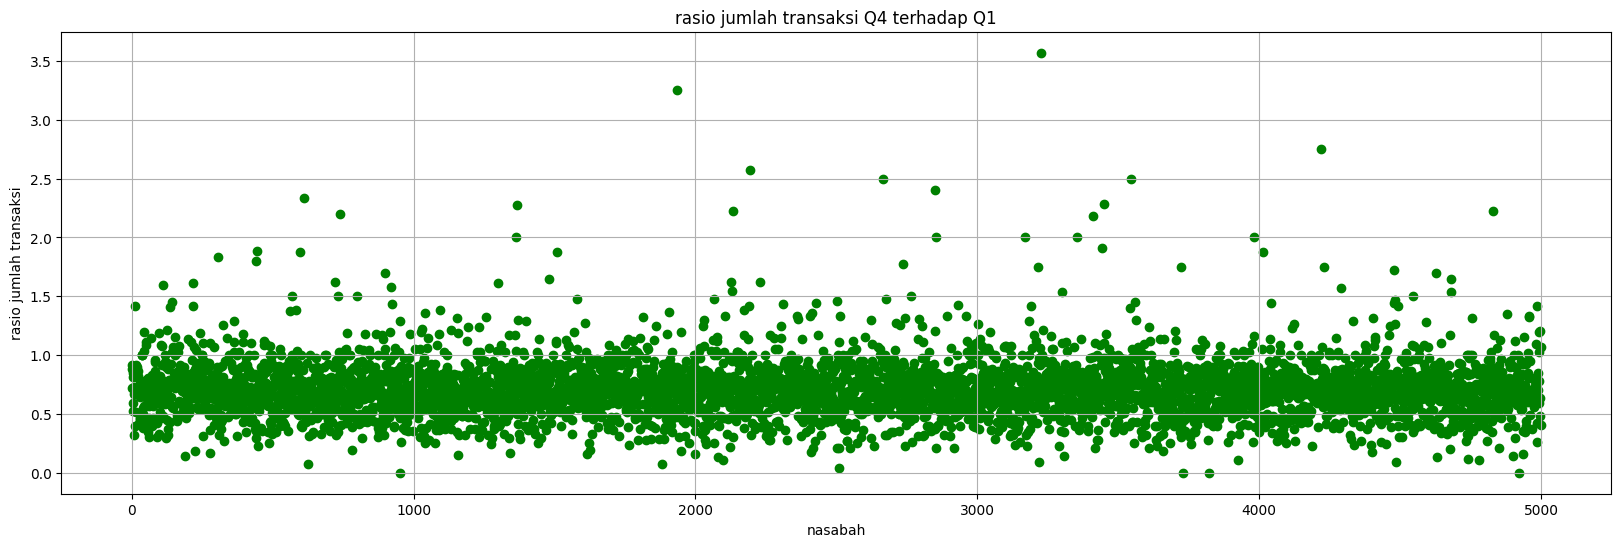

In [350]:
plt.figure(figsize=(20, 6))
plt.scatter(df.index, df['rasio_jumlah_transaksi_Q4_Q1'], color='g')
plt.title('rasio jumlah transaksi Q4 terhadap Q1')
plt.xlabel('nasabah')
plt.ylabel('rasio jumlah transaksi')
plt.grid(True)
plt.show()

## 2.2 Info Data

In [351]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   client_id                     5000 non-null   int64  
 1   label                         5000 non-null   int64  
 2   usia                          5000 non-null   int64  
 3   gender                        5000 non-null   object 
 4   jumlah_tanggungan             5000 non-null   int64  
 5   pendidikan                    5000 non-null   object 
 6   status_nikah                  5000 non-null   object 
 7   penghasilan_tahunan           5000 non-null   object 
 8   tipe_kartu_kredit             5000 non-null   object 
 9   lama_nasabah                  5000 non-null   int64  
 10  jumlah_produk                 5000 non-null   int64  
 11  bulan_nonactive               5000 non-null   int64  
 12  jumlah_kontak                 5000 non-null   int64  
 13  tot

In [352]:
df.isna().sum()

client_id                       0
label                           0
usia                            0
gender                          0
jumlah_tanggungan               0
pendidikan                      0
status_nikah                    0
penghasilan_tahunan             0
tipe_kartu_kredit               0
lama_nasabah                    0
jumlah_produk                   0
bulan_nonactive                 0
jumlah_kontak                   0
total_limit_kredit              0
total_limit_kredit_dipakai      0
sisa_limit_kredit               0
rasio_transaksi_Q4_Q1           0
total_transaksi                 0
jumlah_transaksi                0
rasio_jumlah_transaksi_Q4_Q1    0
rasio_pemakaian                 0
dtype: int64

data tidak ada nilai null

# 3. Data Preparation / Preprocessing

### 3.1 Feature Selection

In [353]:
column = [
    'label',
    'tipe_kartu_kredit',
    'rasio_transaksi_Q4_Q1 ',
    'total_transaksi',
    'jumlah_transaksi',
    'rasio_jumlah_transaksi_Q4_Q1'
]

df = df[column]
df.head()

,label,tipe_kartu_kredit,rasio_transaksi_Q4_Q1,total_transaksi,jumlah_transaksi,rasio_jumlah_transaksi_Q4_Q1
0,0,Blue,0.703,3734,64,0.882
1,0,Blue,0.706,4010,79,0.717
2,0,Blue,0.879,4727,67,0.914
3,0,Blue,0.940,4973,74,0.850
4,0,Blue,0.524,1454,35,0.522


In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   label                         5000 non-null   int64  
 1   tipe_kartu_kredit             5000 non-null   object 
 2   rasio_transaksi_Q4_Q1         5000 non-null   float64
 3   total_transaksi               5000 non-null   int64  
 4   jumlah_transaksi              5000 non-null   int64  
 5   rasio_jumlah_transaksi_Q4_Q1  5000 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 234.5+ KB


data tersebut ternyata tidak mengandung null value, maka bisa dilewati proses pengecekan null value

dan untuk tipe data, semuanya bertipe data numerik, kecuali `tipe kartu kredit`. kita akan ubah ke numnerik

### 3.2 Type Conversion

kategorikal -> numerik

#### 3.2.1 Cek unique value

In [355]:
df['tipe_kartu_kredit'].unique()

array(['Blue', 'Gold', 'Silver', 'Platinum'], dtype=object)

ada 4 jenis kartu kredit, akan diubah ke numerik dengan rincian berikut
* 0 - Blue
* 1 - Gold
* 2 - Silver
* 3 - Platinum

#### 3.2.2 konversi value

In [356]:
df['tipe_kartu_kredit'] = df['tipe_kartu_kredit'].astype(str)
df['tipe_kartu_kredit'] = df['tipe_kartu_kredit'].map({'Blue': 0, 'Gold': 1, 'Silver': 2, 'Platinum': 3})
df['tipe_kartu_kredit'] = df['tipe_kartu_kredit'].astype(int)

df.head()

,label,tipe_kartu_kredit,rasio_transaksi_Q4_Q1,total_transaksi,jumlah_transaksi,rasio_jumlah_transaksi_Q4_Q1
0,0,0,0.703,3734,64,0.882
1,0,0,0.706,4010,79,0.717
2,0,0,0.879,4727,67,0.914
3,0,0,0.940,4973,74,0.850
4,0,0,0.524,1454,35,0.522


In [357]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   label                         5000 non-null   int64  
 1   tipe_kartu_kredit             5000 non-null   int32  
 2   rasio_transaksi_Q4_Q1         5000 non-null   float64
 3   total_transaksi               5000 non-null   int64  
 4   jumlah_transaksi              5000 non-null   int64  
 5   rasio_jumlah_transaksi_Q4_Q1  5000 non-null   float64
dtypes: float64(2), int32(1), int64(3)
memory usage: 215.0 KB


semua data sudah bertipe data numerik

### 3.3 Cek Sampling label Data


<Axes: xlabel='label'>

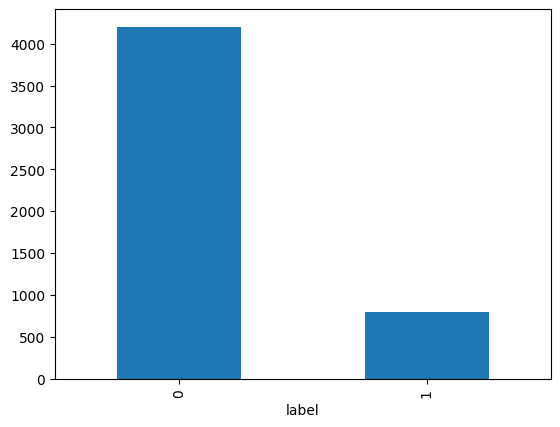

In [358]:
df['label'].value_counts().plot(kind='bar')

dikarenakan adanya ketidak seimbangan jumlah label, maka kemungkinan akan dilakukan random sampling terhadap 2 label. sementara akan dibiarkan dulu. dan jika pada evaluasi modelling menghasilkan nilai yang kurang, maka model akan ditunning + random sampling

# 4. Modelling

pada modelling, akan dilakukan prediksi berdasarkan fitur yang digunakan.
akan dibandingkan 2 model yang digunakan untuk melihat perbandingan model yang terbaik

## 4.1 Data Splitting

In [359]:
X = df.drop(columns=['label'])
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.3 Data Split to train & Test

In [361]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.4 Data Pipeline

sebenarnya, tanpa pipeline juga bisa

In [362]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

## 4.5 Train data

In [363]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', DecisionTreeClassifier(random_state=42))])

## 4.6 Cek Akurasi

In [364]:
from sklearn.metrics import classification_report

def model_performance(model):
    y_train_pred = pipeline.predict(X_train)
    y_test_pred  = pipeline.predict(X_test)
    print('Model Performance on Data Training')
    print(classification_report(y_train,y_train_pred))

    print('Model Performance on Data Testing')
    print(classification_report(y_test,y_test_pred))

In [365]:
model_performance(pipeline)

Model Performance on Data Training
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3349
           1       1.00      1.00      1.00       651

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Model Performance on Data Testing
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       851
           1       0.75      0.70      0.73       149

    accuracy                           0.92      1000
   macro avg       0.85      0.83      0.84      1000
weighted avg       0.92      0.92      0.92      1000



sejauh ini, akurasi tampak bagus (semua diatas 90%). namun akurasi 100% itu tidak normal, maka kita perlu lakukan sesuatu

# 5. Re-Modelling

setelah mempertimbangkan data sebelumnya pada label, akan dilakukan over sampling, untuk menambah salah satu label

## 5.1 Random Sampling

In [366]:
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)

In [367]:
print(f'Original dataset shape: {Counter(y)}')
print(f'Resampled dataset shape: {Counter(y_under)}')

Original dataset shape: Counter({0: 4200, 1: 800})
Resampled dataset shape: Counter({0: 800, 1: 800})


setelah di over sampling, jumlah label sudah sama

## 5.2 Re-Model dengan DT

In [368]:
pipeline.fit(X_under, y_under)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [369]:
model_performance(pipeline)

Model Performance on Data Training
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      3349
           1       0.67      1.00      0.80       651

    accuracy                           0.92      4000
   macro avg       0.83      0.95      0.88      4000
weighted avg       0.95      0.92      0.93      4000

Model Performance on Data Testing
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       851
           1       0.66      1.00      0.79       149

    accuracy                           0.92      1000
   macro avg       0.83      0.95      0.87      1000
weighted avg       0.95      0.92      0.93      1000



setelah dilakukan under sampling, akurasi tidak overfit ataupun underfit.

## 5.3 Evaluation DT

In [370]:
def predict(input_data):
    input_df = pd.DataFrame([input_data])
    prediction = pipeline.predict(input_df)
    return prediction[0]

In [371]:

np.random.seed(42)
data_list = []

for _ in range(50):
    input_data = {
        'tipe_kartu_kredit': np.random.randint(0, 4),
        'rasio_transaksi_Q4_Q1 ': np.random.uniform(0.0, 1.0),
        'total_transaksi': np.random.randint(0, 1000),
        'jumlah_transaksi': np.random.randint(0, 200),
        'rasio_jumlah_transaksi_Q4_Q1': np.random.uniform(0.0, 1.0)
    }
    data_list.append(input_data)

df_input = pd.DataFrame(data_list)

df_input['Prediction'] = df_input.apply(predict, axis=1)
df_input

,tipe_kartu_kredit,rasio_transaksi_Q4_Q1,total_transaksi,jumlah_transaksi,rasio_jumlah_transaksi_Q4_Q1,Prediction
0,2,0.796543,270,106,0.779691,1
1,0,0.156019,466,74,0.459249,1
2,0,0.601115,663,130,0.020584,1
3,1,0.721999,413,37,0.000779,1
4,3,0.183405,459,57,0.524756,1
5,3,0.023062,474,58,0.399861,1
6,3,0.292145,975,14,0.456070,1
7,2,0.618386,875,54,0.983231,1
8,0,0.046450,818,134,0.170524,1
9,2,0.013265,600,59,0.563288,1


walaupun akurasi bagus, tetapi model tidak mau mempredict dengan bagus.

## 6. Modelling dengan XGBoost

## 6.1 Pipeline XGBoost

In [372]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', XGBClassifier(random_state=42))
])

## 6.2 Train data

In [373]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

## 6.3 Cek Akurasi

In [374]:
model_performance(pipeline)

Model Performance on Data Training
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3349
           1       0.99      0.99      0.99       651

    accuracy                           1.00      4000
   macro avg       1.00      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000

Model Performance on Data Testing
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       851
           1       0.80      0.74      0.77       149

    accuracy                           0.93      1000
   macro avg       0.88      0.86      0.87      1000
weighted avg       0.93      0.93      0.93      1000



akurasi masih tidak semestinya

## 6.4 Under Sampling

In [375]:
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)

In [376]:
pipeline.fit(X_under, y_under)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

## 6.5 Cek re-model with under sampling data

In [377]:
model_performance(pipeline)

Model Performance on Data Training
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      3349
           1       0.72      1.00      0.84       651

    accuracy                           0.94      4000
   macro avg       0.86      0.96      0.90      4000
weighted avg       0.95      0.94      0.94      4000

Model Performance on Data Testing
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       851
           1       0.72      1.00      0.84       149

    accuracy                           0.94      1000
   macro avg       0.86      0.97      0.90      1000
weighted avg       0.96      0.94      0.95      1000



## 6.6 Evaluation XGBoost

In [378]:

np.random.seed(42)
data_list = []

for _ in range(30):
    input_data = {
        'tipe_kartu_kredit': np.random.randint(0, 4),
        'rasio_transaksi_Q4_Q1 ': np.random.uniform(0.0, 1.0),
        'total_transaksi': np.random.randint(0, 1000),
        'jumlah_transaksi': np.random.randint(0, 200),
        'rasio_jumlah_transaksi_Q4_Q1': np.random.uniform(0.0, 1.0)
    }
    data_list.append(input_data)

df_input = pd.DataFrame(data_list)

df_input['Prediction'] = df_input.apply(predict, axis=1)
df_input

,tipe_kartu_kredit,rasio_transaksi_Q4_Q1,total_transaksi,jumlah_transaksi,rasio_jumlah_transaksi_Q4_Q1,Prediction
0,2,0.796543,270,106,0.779691,0
1,0,0.156019,466,74,0.459249,0
2,0,0.601115,663,130,0.020584,0
3,1,0.721999,413,37,0.000779,1
4,3,0.183405,459,57,0.524756,1
5,3,0.023062,474,58,0.399861,1
6,3,0.292145,975,14,0.456070,1
7,2,0.618386,875,54,0.983231,1
8,0,0.046450,818,134,0.170524,0
9,2,0.013265,600,59,0.563288,1


model sudah memprediksi dengan baik

# 7. Kesimpulan

dari hasil prediksi yaaang dilakuan pada sekumpulan input random data, dapat dilihat jika kebanyakan dari data rasio tidak terlalu menunjukkan hasil significant. sedangkan jumlah dan total transaksi menunjukkan hasil yang mudah dilihat. yaitu value yang kecil dari jumlah dan atau total transaksi menunjukkan sangat mempengaruhi nasabah tidak melanjutkan kartu kreditnya (CHURN).
rekomendasi yang diberikan:
- memberi diskon terkait jumlah kredit yang dapat diambil.
- meberikan benefit/fasilitas terntentu kepada nasabah yang melakukan transaksi, sehingga menambah motivasi nasabah untuk sering menggunakan kartu kredit.
-  Meningkatkan program loyalitas dengan memberikan reward atau poin yang dapat ditukarkan dengan hadiah menarik atau cashback untuk setiap transaksi yang dilakukan menggunakan kartu kredit.